# Mask R-CNN Image Segmentation Demo
This Colab enables you to use a Mask R-CNN model that was trained on Cloud TPU to perform instance segmentation on a sample input image. The resulting predictions are overlayed on the sample image as boxes, instance masks, and labels. You can also experiment with your own images by editing the input image URL.

### About Mask R-CNN
The Mask R-CNN model addresses one of the most difficult computer vision challenges: image segmentation. Image segmentation is the task of detecting and distinguishing multiple objects within a single image. In particular, Mask R-CNN performs "instance segmentation," which means that different instances of the same type of object in the input image, for example, car, should be assigned distinct labels.

Self-Note: edited to work work tensorflow version 2

# Instructions
<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Use a free Cloud TPU</h3>
 
   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   2. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER.

## Download the source code
Download the source code of the Mask R-CNN model.

In [ ]:
!git clone https://github.com/tensorflow/tpu/

Cloning into 'tpu'...
remote: Enumerating objects: 10975, done.
remote: Counting objects: 100% (1177/1177), done.
remote: Compressing objects: 100% (607/607), done.
remote: Total 10975 (delta 658), reused 1003 (delta 545), pack-reused 9798
Receiving objects: 100% (10975/10975), 46.78 MiB | 25.13 MiB/s, done.
Resolving deltas: 100% (7696/7696), done.


## Import libraries

In [ ]:
from IPython import display
from PIL import Image
import numpy as np
%tensorflow_version 2
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Load the COCO index mapping
This Colab uses a pretrained checkpoint of the Mask R-CNN model that is trained using the COCO dataset. Here is the mapping between the indices that the model predicts and the categories in text.

In [ ]:
ID_MAPPING = {
    1: 'person',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

## Load an image
Now, you can load an image. Use either the sample image included here, or update the field with an image of your choice.

In [ ]:
#@title Run to upload the input image and generate/upload masks{ display-mode: "form" }
from google.colab import files
from ipywidgets import Button, HBox, VBox, widgets
from IPython.display import display, clear_output
import shutil 

class StopExecution(Exception):
    def _render_traceback_(self):
        pass


def upload_file():
    uploaded = files.upload()
    try:
        fn = list(uploaded.keys())[0]
    except:
        print ("Please upload a valid image file!")
        raise StopExecution
    print('Uploaded file "{name}" of {length} bytes'.format(name=fn,length=len(uploaded[fn])))
    return fn


print ("UPLOAD INPUT FILE")
fn = upload_file()
shutil.move(fn, "input_img.jpg")


UPLOAD INPUT FILE


Saving image1-2019-10-0818-11-09.jpeg to image1-2019-10-0818-11-09.jpeg
Uploaded file "image1-2019-10-0818-11-09.jpeg" of 675283 bytes


'input_img.jpg'

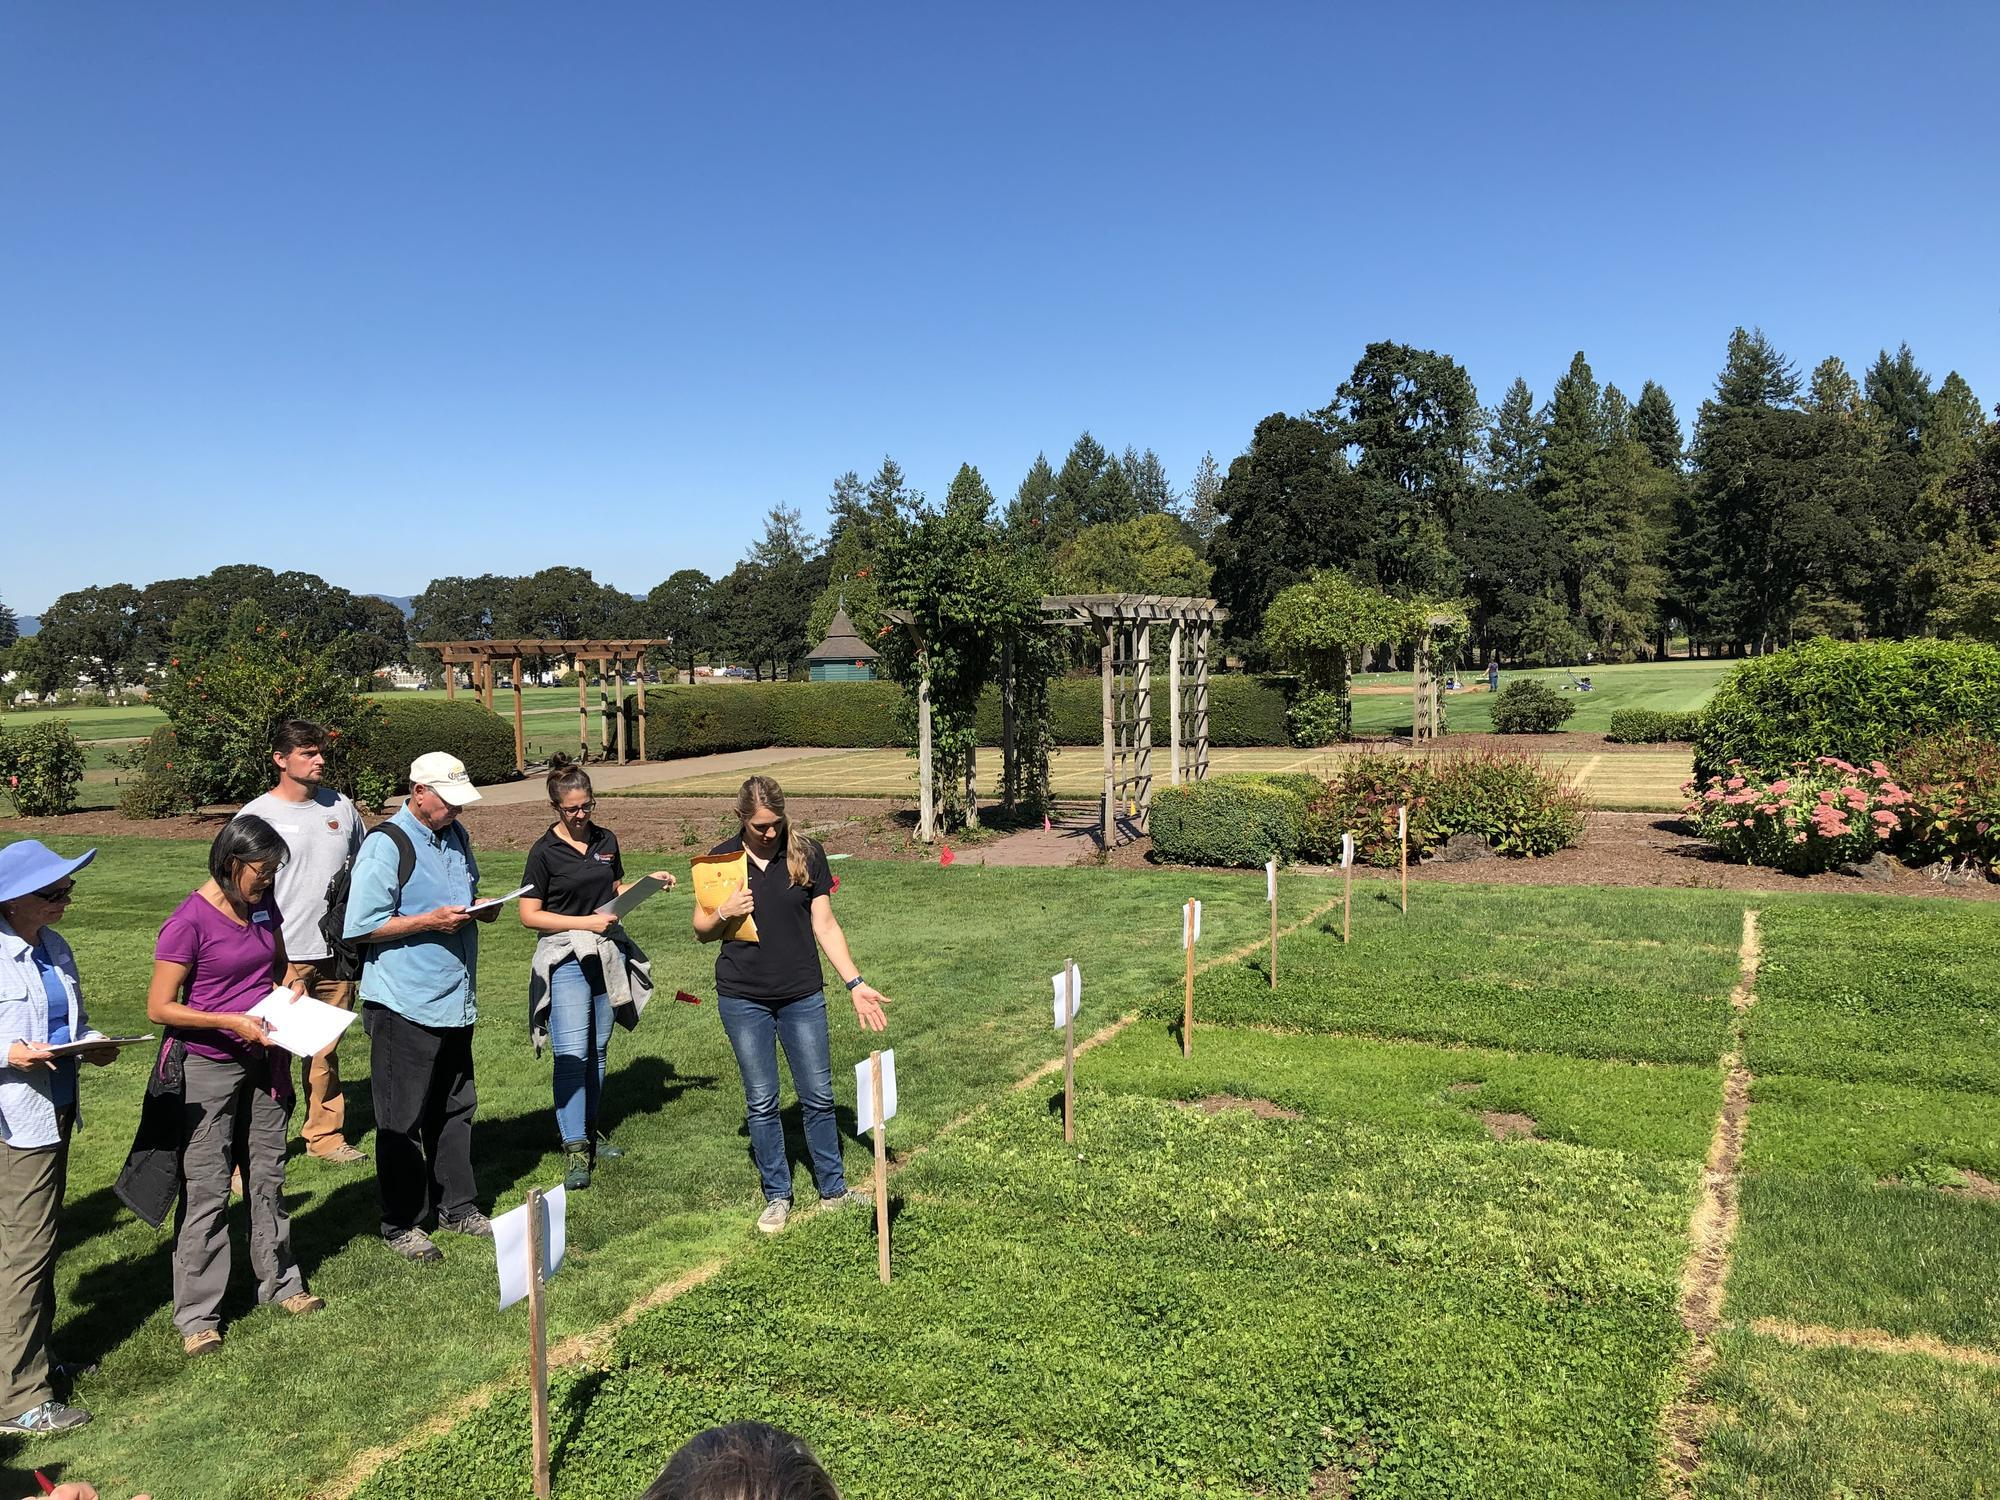

In [ ]:
# !wget https://www.kinnevik.com/globalassets/images/3.-our-investments/investments/gfg-2.jpg -O test.jpg
# image_path = 'test.jpg'
image_path = "input_img.jpg"

with open(image_path, 'rb') as f:
  np_image_string = np.array([f.read()])
  
image = Image.open(image_path)
width, height = image.size
# print(image.size)
np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

display.display(display.Image(image_path, width=1024))

## Create a Tensorflow session
Now let us create a Tensorflow session to run the inference. You can either connect to a TPU or a normal CPU backend.

In [ ]:
use_tpu = True #@param {type:"boolean"}
if use_tpu:
  import os
  import pprint

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)

  session = tf.compat.v1.Session(TPU_ADDRESS, graph=tf.Graph())
  print('TPU devices:')
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph=tf.Graph())

TPU address is grpc://10.4.248.114:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, -7307425540114849452),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 8589934592, -7518671852763217567),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 7061878289730730807),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, -5365459532639396638),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 3424906769921746755),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 7801213614073730201),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 6742806498418055855),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, -33095396310743152),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 345111259

# Load the pretrained model
Loading the COCO pretrained saved model from the public GCS bucket. 

In [ ]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850' #@param {type:"string"}
_ = tf.compat.v1.saved_model.loader.load(session, ['serve'], saved_model_dir)

## Perform instance segmentation and retrieve the predictions
Now let's run the inference and process the predictions from the model.


In [ ]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, image_info = session.run(
    ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0', 'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
    feed_dict={'Placeholder:0': np_image_string})

num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

In [ ]:
len(segmentations)

44

In [ ]:
print(detection_boxes[0:6])

[[  42.31961   118.134705  702.53467   369.06104 ]
 [ 204.07962   844.4298    619.9171   1112.0608  ]
 [ 131.93916   513.0297    611.9576    678.21796 ]
 [ 254.4032    382.8211    695.7975    574.1755  ]
 [ 350.1234    309.89706   667.0906    456.52817 ]
 [ 285.67148   613.71704   698.42285   842.534   ]]


In [ ]:
print(detection_classes)

[ 1  1  1  1  1  1  1 28 31 31  1  3 27  1  1 34  1  1 31 31 31 15  1 62
 31 31 32 34 32 27 39 31 84  1 39 39 34  1 31 39 27 27 31]


In [ ]:
print(detection_boxes.tolist())

[[42.319610595703125, 118.13470458984375, 702.53466796875, 369.06103515625], [204.07962036132812, 844.4298095703125, 619.9171142578125, 1112.060791015625], [131.9391632080078, 513.0297241210938, 611.9575805664062, 678.2179565429688], [254.4031982421875, 382.82110595703125, 695.7974853515625, 574.1754760742188], [350.1234130859375, 309.8970642089844, 667.090576171875, 456.5281677246094], [285.6714782714844, 613.717041015625, 698.4228515625, 842.5339965820312], [332.338623046875, 1135.3834228515625, 478.3181457519531, 1185.333984375], [259.8721618652344, 324.1208801269531, 305.74139404296875, 358.64862060546875], [438.2925109863281, 660.5526123046875, 682.8499755859375, 847.0891723632812], [171.6560516357422, 1079.4146728515625, 463.56646728515625, 1186.83984375], [449.0660400390625, 968.8511962890625, 723.29345703125, 1175.0010986328125], [345.5379333496094, 640.5194091796875, 506.334716796875, 723.8513793945312], [253.3246612548828, 326.55078125, 308.64068603515625, 352.4029235839844],

In [ ]:
print(detection_scores.tolist())

[0.9997864961624146, 0.9992194771766663, 0.9985308051109314, 0.994220495223999, 0.9884148240089417, 0.9792996644973755, 0.9280958771705627, 0.8625792860984802, 0.8196009397506714, 0.7309490442276001, 0.5594767928123474, 0.5172929763793945, 0.47468701004981995, 0.4729762673377991, 0.4700193703174591, 0.4641920328140259, 0.38683247566223145, 0.31758561730384827, 0.285036563873291, 0.2519293427467346, 0.2091263085603714, 0.1827026903629303, 0.14813610911369324, 0.14485928416252136, 0.13949404656887054, 0.1285587102174759, 0.11625645309686661, 0.10086395591497421, 0.09511105716228485, 0.0820307731628418, 0.08024416118860245, 0.07778175175189972, 0.07667510211467743, 0.07421280443668365, 0.07192476838827133, 0.06566110253334045, 0.06532049924135208, 0.0601077675819397, 0.05984792113304138, 0.05912308394908905, 0.058824338018894196, 0.05807679146528244, 0.05774158611893654, 0.055434249341487885]


In [ ]:
print(detection_classes.tolist())

[1, 1, 1, 1, 62, 1, 86, 47, 62, 64, 15, 62, 44, 62, 46, 47, 44, 62, 64, 62, 15, 62, 77, 47, 77, 47, 62, 15, 15, 63, 62, 75, 44, 44, 62, 47, 15, 62, 62, 64, 62, 15, 77, 65]


## Visualize the detection results
Time to check out the result!

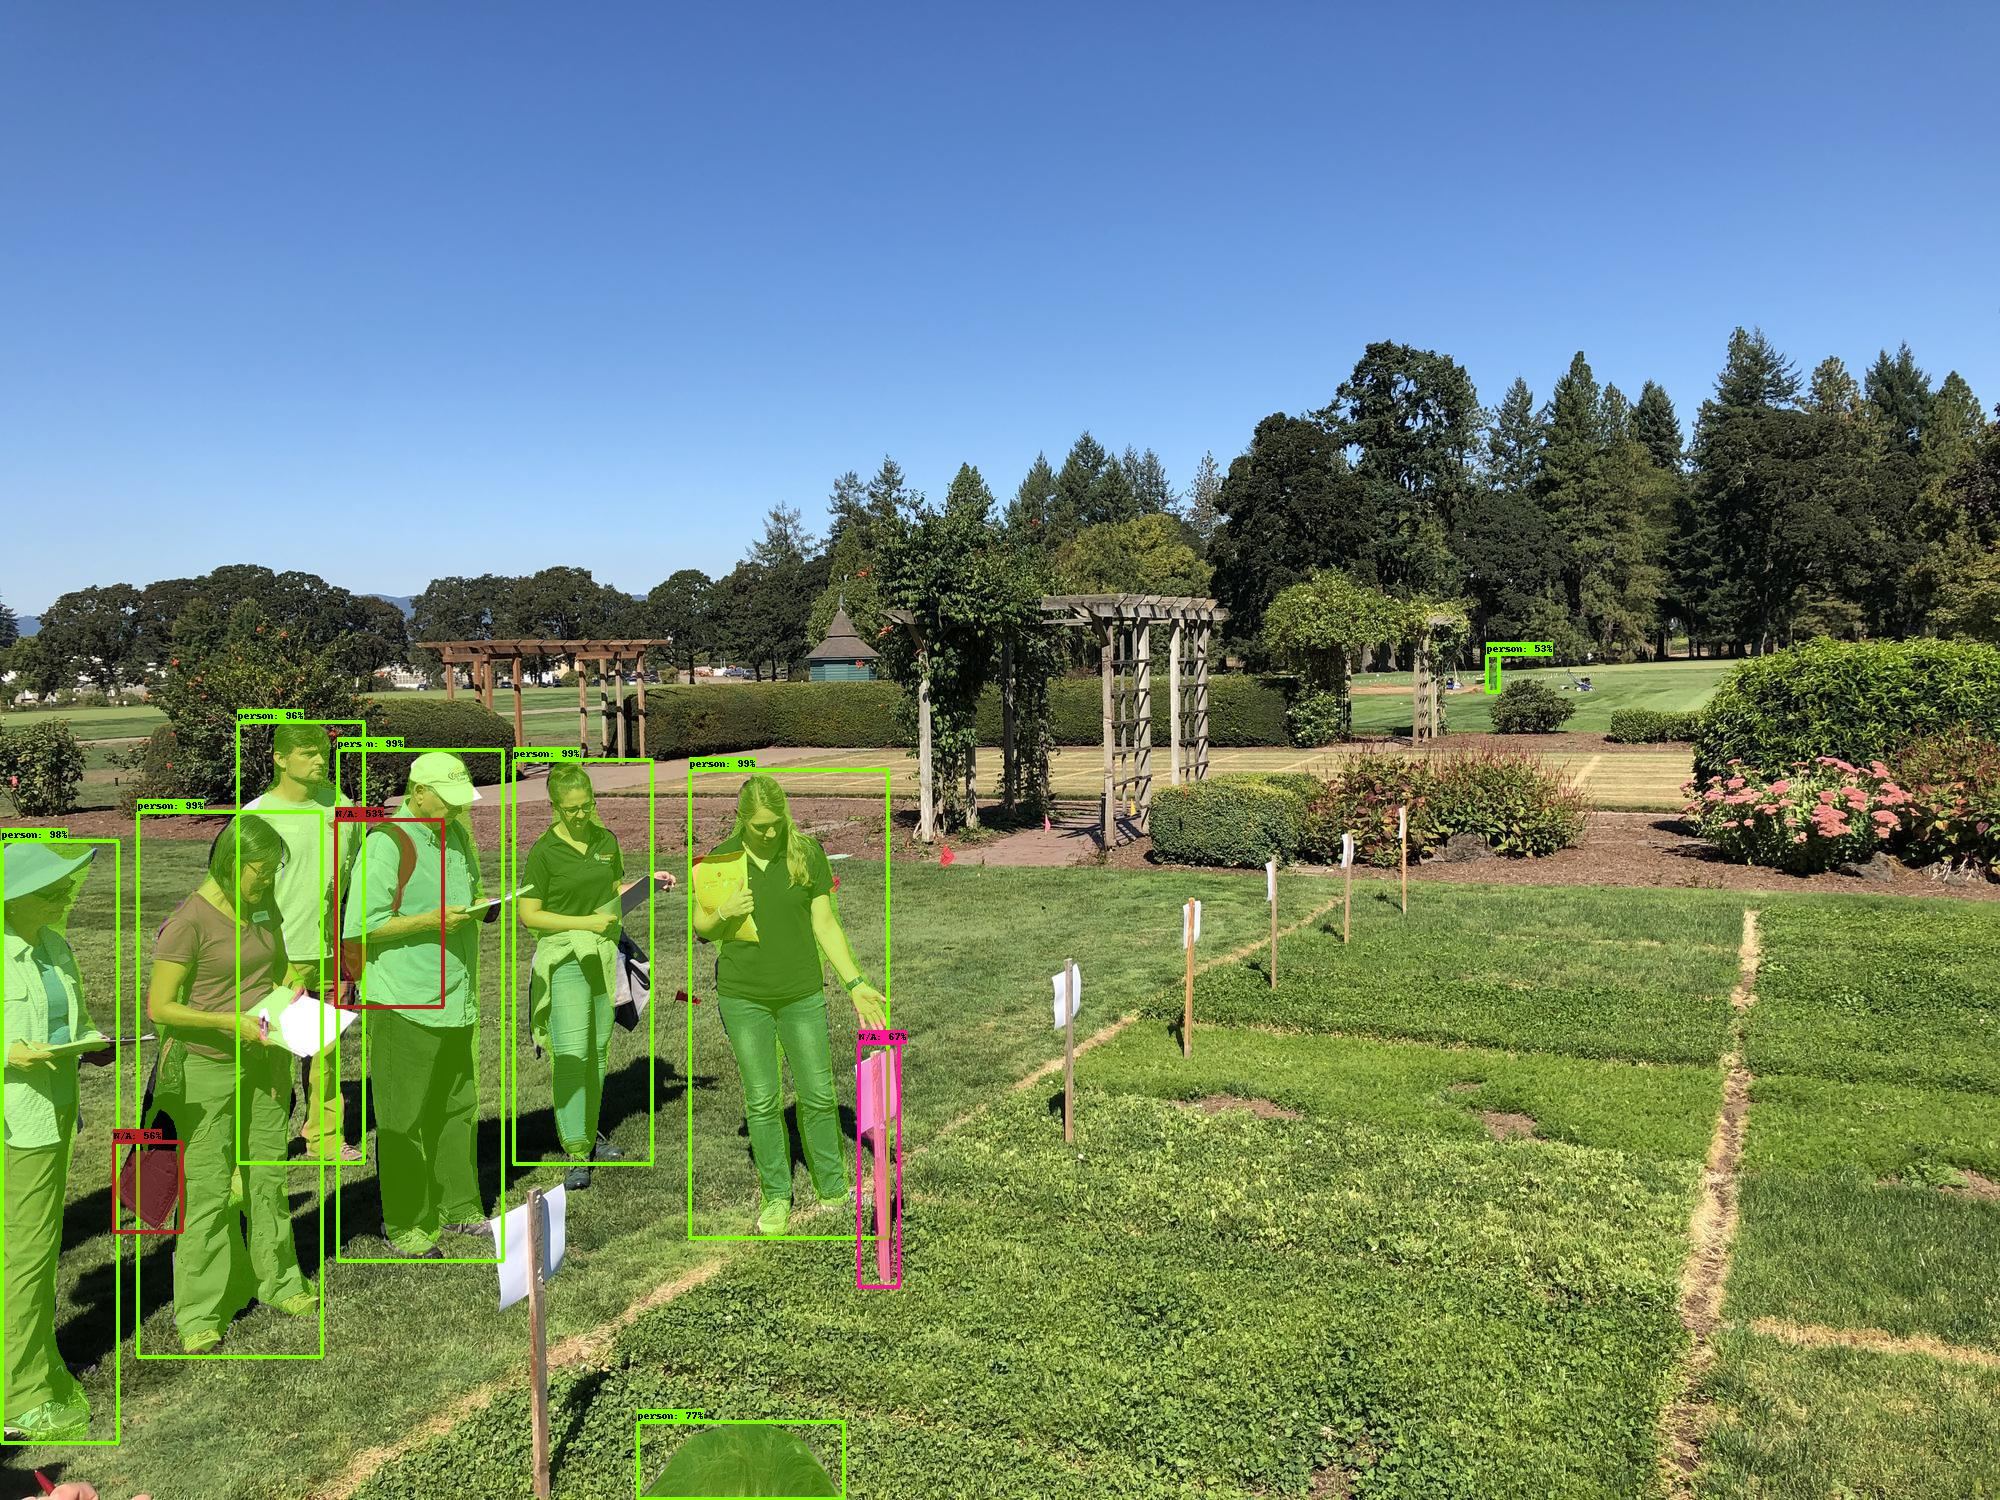

In [ ]:
max_boxes_to_draw = 100   #@param {type:"integer"}
min_score_thresh = 0.52    #@param {type:"slider", min:0, max:1, step:0.01}

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks=segmentations,
    use_normalized_coordinates=False,
    max_boxes_to_draw=max_boxes_to_draw,
    min_score_thresh=min_score_thresh)
output_image_path = 'test_results.jpg'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=1024))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

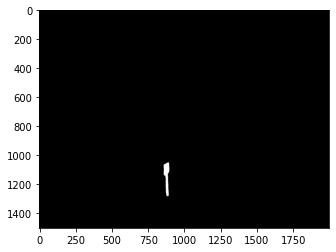

In [ ]:
def mask_gen(index):
  s = segmentations[index]
  s[s>0] = 255
  s = np.array([s, s, s])
  s = s.transpose(1,2,0)
  plt.imshow(s)
  im = Image.fromarray(s)
  im.save("a{}.png".format(index))

for i in range(8):
  mask_gen(i)